In [2]:
# load these packages
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.ml import feature, regression, evaluation, Pipeline, clustering, classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Bucketizer

import pyspark.sql.functions as f
from pyspark.sql import functions as fn, Row
from pyspark.sql.functions import when, lit, udf, year, month, dayofmonth, hour
from pyspark.sql.types import *


In [3]:
data = spark.read.csv('data.csv', inferSchema=True, header=True)

# 1. Basic Dataset Inspection

In [4]:
data.limit(2).toPandas()

,Year,Crash Descriptor,Time,Date,Day of Week,Police Report,Lighting Conditions,Municipality,Collision Type Descriptor,County Name,Road Descriptor,Weather Conditions,Traffic Control Device,Road Surface Conditions,DOT Reference Marker Location,Pedestrian Bicyclist Action,Event Descriptor,Number of Vehicles Involved
0,2016,Property Damage Accident,17:14,12/31/2016,Saturday,Y,Dark-Road Unlighted,MARTINSBURG,OTHER,LEWIS,Curve and Grade,Cloudy,None,Wet,26 74061244,Not Applicable,Deer,1
1,2016,Property Damage Accident,5:30,12/31/2016,Saturday,Y,Dark-Road Unlighted,BROOKHAVEN,SIDESWIPE,SUFFOLK,Straight and Level,Clear,None,Dry,None,Not Applicable,"Other Motor Vehicle, Collision With",2


In [5]:
data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Crash Descriptor: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Police Report: string (nullable = true)
 |-- Lighting Conditions: string (nullable = true)
 |-- Municipality: string (nullable = true)
 |-- Collision Type Descriptor: string (nullable = true)
 |-- County Name: string (nullable = true)
 |-- Road Descriptor: string (nullable = true)
 |-- Weather Conditions: string (nullable = true)
 |-- Traffic Control Device: string (nullable = true)
 |-- Road Surface Conditions: string (nullable = true)
 |-- DOT Reference Marker Location: string (nullable = true)
 |-- Pedestrian Bicyclist Action: string (nullable = true)
 |-- Event Descriptor: string (nullable = true)
 |-- Number of Vehicles Involved: integer (nullable = true)



In [6]:
data.count(), len(data.columns)

(895916, 18)

In [7]:
Crashes = data.groupBy('Crash Descriptor').count()

Crashes.show()

+--------------------+------+
|    Crash Descriptor| count|
+--------------------+------+
|     Injury Accident|183322|
|Property Damage &...|171596|
|Property Damage A...|538018|
|      Fatal Accident|  2980|
+--------------------+------+



In [8]:
data.describe(['Number of Vehicles Involved']).show()

+-------+---------------------------+
|summary|Number of Vehicles Involved|
+-------+---------------------------+
|  count|                     895916|
|   mean|          1.776373008183803|
| stddev|         0.6387171374051479|
|    min|                          1|
|    max|                         50|
+-------+---------------------------+



In [8]:
data.groupBy('Day of Week').count().show()

+-----------+------+
|Day of Week| count|
+-----------+------+
|  Wednesday|132954|
|    Tuesday|131951|
|     Friday|147681|
|   Thursday|135332|
|   Saturday|118697|
|     Monday|128593|
|     Sunday|100708|
+-----------+------+



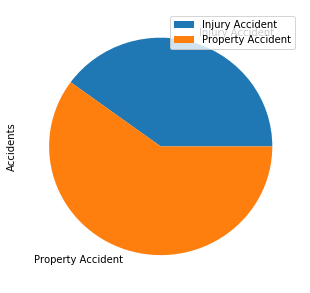

In [9]:
dff3 = pd.DataFrame({'Accidents': [357898, 538018]}, index=['Injury Accident', 'Property Accident'])
plot = dff3.plot.pie(y='Accidents', figsize=(5, 5))

# 2. Preprocessing

## 2.1 Classify Instances: Injury- vs. Property Damage- Accidents

In [10]:
# Creating a new column to classify instances: Property Damage Accident: 0, Injury Accident = 1
df = data.withColumn('Accident Descriptor', when((data['Crash Descriptor'] == 'Property Damage & Injury Accident') | 
                                                 (data['Crash Descriptor'] == 'Injury Accident') | 
                                                 (data['Crash Descriptor'] == 'Fatal Accident'), 1).otherwise(0))
df.printSchema()
df_pd = df.toPandas()

root
 |-- Year: integer (nullable = true)
 |-- Crash Descriptor: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Police Report: string (nullable = true)
 |-- Lighting Conditions: string (nullable = true)
 |-- Municipality: string (nullable = true)
 |-- Collision Type Descriptor: string (nullable = true)
 |-- County Name: string (nullable = true)
 |-- Road Descriptor: string (nullable = true)
 |-- Weather Conditions: string (nullable = true)
 |-- Traffic Control Device: string (nullable = true)
 |-- Road Surface Conditions: string (nullable = true)
 |-- DOT Reference Marker Location: string (nullable = true)
 |-- Pedestrian Bicyclist Action: string (nullable = true)
 |-- Event Descriptor: string (nullable = true)
 |-- Number of Vehicles Involved: integer (nullable = true)
 |-- Accident Descriptor: integer (nullable = false)



In [11]:
# Show overview of classfied instances
Crashes1 = Crashes.withColumn('Accident Descriptor', when((data['Crash Descriptor'] == 'Property Damage & Injury Accident') | 
                                                 (data['Crash Descriptor'] == 'Injury Accident') | 
                                                 (data['Crash Descriptor'] == 'Fatal Accident'), 1).otherwise(0))
Crashes_pd = Crashes1.toPandas()

In [12]:
Crashes_pd

,Crash Descriptor,count,Accident Descriptor
0,Injury Accident,183322,1
1,Property Damage & Injury Accident,171596,1
2,Property Damage Accident,538018,0
3,Fatal Accident,2980,1


# 3. Data Exploration

### 1. Time

In [13]:
# 5 Buckets: 0-4, 5-11, 12-16, 17-22, 23-34
df_time = df.withColumn('Hour', hour('Time'))
bucketizer = Bucketizer(splits=[0,5,12,17,23,24],inputCol="Hour", outputCol="Hour_buckets")
df_time2 = bucketizer.setHandleInvalid("keep").transform(df_time)

In [14]:
# 5 Buckets: 0-4 = Night, 5-11 = Morning, 12-16 = Afternoon, 17-22 = Evening, 23-34 = Night
t = {0.0:"Night", 1.0: "Morning", 2.0:"Afternoon", 3.0: "Evening", 4.0:"Night"}
udf_foo = udf(lambda x: t[x], StringType())
df_time3 = df_time2.withColumn("Time of the Day", udf_foo("Hour_buckets"))
df_time3_pd = df_time3.toPandas()

In [15]:
Injuries = df_time3.filter((f.col('Accident Descriptor') == 1)).toPandas()
Injuries1 = df_time3.filter((f.col('Accident Descriptor') == 1))

No_Injuries = df_time3.filter((f.col('Accident Descriptor') == 0)).toPandas()
No_Injuries1 = df_time3.filter((f.col('Accident Descriptor') == 0))

In [16]:
time = pd.DataFrame(Injuries['Time of the Day'].value_counts())
time2 = pd.DataFrame(No_Injuries['Time of the Day'].value_counts())

time['Time Share'] = time['Time of the Day']/sum(time['Time of the Day'])
time['Accident Descriptor'] = 'Injury Accident'

time2['Time Share'] = time2['Time of the Day']/sum(time2['Time of the Day'])
time2['Accident Descriptor'] = 'Property Damage Accident'

time3 = pd.concat([time, time2], axis=0)
time3['Time Descriptor'] = time3.index

In [17]:
time3

,Time of the Day,Time Share,Accident Descriptor,Time Descriptor
Afternoon,119724,0.334520,Injury Accident,Afternoon
Evening,106388,0.297258,Injury Accident,Evening
Morning,97614,0.272743,Injury Accident,Morning
Night,34172,0.095480,Injury Accident,Night
Afternoon,164047,0.304910,Property Damage Accident,Afternoon
Morning,158806,0.295169,Property Damage Accident,Morning
Evening,147066,0.273348,Property Damage Accident,Evening
Night,68099,0.126574,Property Damage Accident,Night


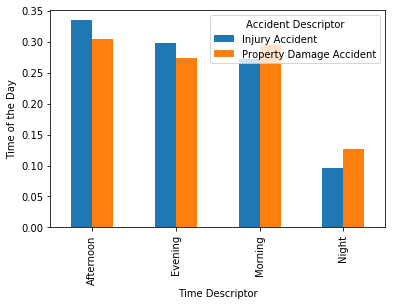

In [18]:
time3.pivot("Time Descriptor", "Accident Descriptor", "Time Share").plot(kind='bar')
plt.ylabel('Time of the Day')
plt.show()

### 2. Road Conditions

In [19]:
road = pd.DataFrame(Injuries['Road Descriptor'].value_counts())
road2 = pd.DataFrame(No_Injuries['Road Descriptor'].value_counts())

road['Road Descriptor Share'] = road['Road Descriptor']/sum(road['Road Descriptor'])
road['Accident Descriptor'] = 'Injury Accident'

road2['Road Descriptor Share'] = road2['Road Descriptor']/sum(road2['Road Descriptor'])
road2['Accident Descriptor'] = 'Property Damage Accident'

road3 = pd.concat([road, road2], axis=0)
road3['Road Description'] = road3.index

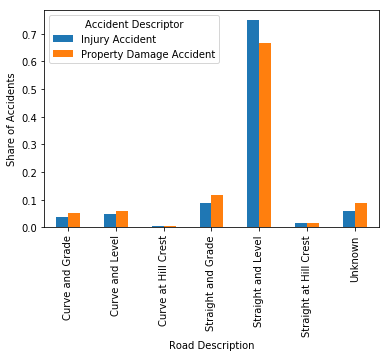

In [20]:
road3.pivot("Road Description", "Accident Descriptor", "Road Descriptor Share").plot(kind='bar')
plt.ylabel('Share of Accidents')
plt.show()

### 3. Weekday

In [21]:
day = pd.DataFrame(Injuries['Day of Week'].value_counts())
day2 = pd.DataFrame(No_Injuries['Day of Week'].value_counts())

day['Day of Week Share'] = day['Day of Week']/sum(day['Day of Week'])
day['Accident Descriptor'] = 'Injury Accident'

day2['Day of Week Share'] = day2['Day of Week']/sum(day2['Day of Week'])
day2['Accident Descriptor'] = 'Property Damage Accident'

day3 = pd.concat([day, day2], axis=0)
day3['Day of Week'] = day3.index

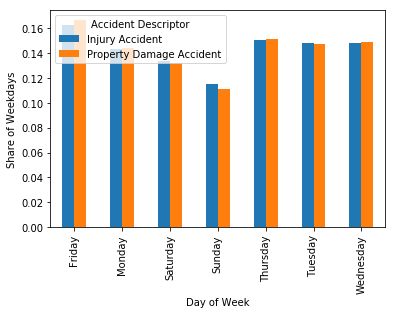

In [22]:
day3.pivot("Day of Week", "Accident Descriptor", "Day of Week Share").plot(kind='bar')
plt.ylabel('Share of Weekdays')
plt.show()

### 4. Road Surface Conditions

In [23]:
surface = pd.DataFrame(Injuries['Road Surface Conditions'].value_counts())
surface2 = pd.DataFrame(No_Injuries['Road Surface Conditions'].value_counts())

surface['Road Surface Condition Share'] = surface['Road Surface Conditions']/sum(surface['Road Surface Conditions'])
surface['Accident Descriptor'] = 'Injury Accident'

surface2['Road Surface Condition Share'] = surface2['Road Surface Conditions']/sum(surface2['Road Surface Conditions'])
surface2['Accident Descriptor'] = 'Property Damage Accident'

surface3 = pd.concat([surface, surface2], axis=0)
surface3['Surface Condition'] = surface3.index

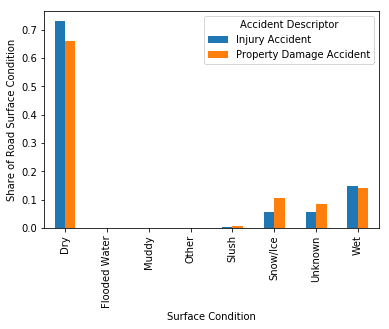

In [24]:
surface3.pivot("Surface Condition", "Accident Descriptor", "Road Surface Condition Share").plot(kind='bar')
plt.ylabel('Share of Road Surface Condition')
plt.show()

### 5. Weather Conditions

In [25]:
weather = pd.DataFrame(Injuries['Weather Conditions'].value_counts())
weather2 = pd.DataFrame(No_Injuries['Weather Conditions'].value_counts())

weather['Weather Condition Share'] = weather['Weather Conditions']/sum(weather['Weather Conditions'])
weather['Accident Descriptor'] = 'Injury Accident'

weather2['Weather Condition Share'] = weather2['Weather Conditions']/sum(weather2['Weather Conditions'])
weather2['Accident Descriptor'] = 'Property Damage Accident'

weather3 = pd.concat([weather, weather2], axis=0)
weather3['Weather Condition'] = weather3.index

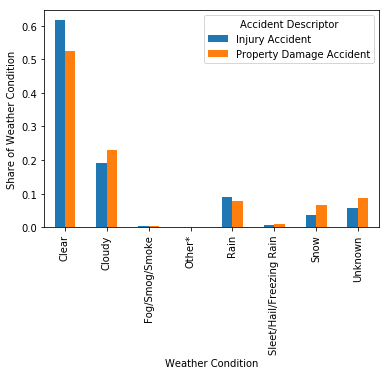

In [26]:
weather3.pivot("Weather Condition", "Accident Descriptor", "Weather Condition Share").plot(kind='bar')
plt.ylabel('Share of Weather Condition')
plt.show()

### 6. Event Descriptor

In [27]:
event = pd.DataFrame(Injuries['Event Descriptor'].value_counts())
event2 = pd.DataFrame(No_Injuries['Event Descriptor'].value_counts())

event['Event Share'] = event['Event Descriptor']/sum(event['Event Descriptor'])
event['Accident Descriptor'] = 'Injury Accident'

event2['Event Share'] = event2['Event Descriptor']/sum(event2['Event Descriptor'])
event2['Accident Descriptor'] = 'Property Damage Accident'

event3 = pd.concat([event, event2], axis=0)
event3['Event Descriptor'] = event3.index

In [28]:
event3_filtered = event3[event3['Event Share'] > 0.03]

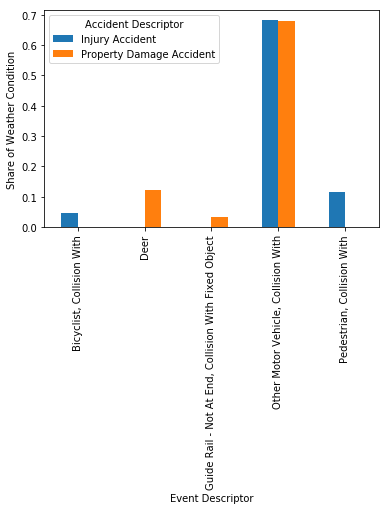

In [29]:
event3_filtered.pivot("Event Descriptor", "Accident Descriptor", "Event Share").plot(kind='bar')
plt.ylabel('Share of Weather Condition')
plt.show()

### 7. Lighting Conditions

In [30]:
Light = pd.DataFrame(Injuries['Lighting Conditions'].value_counts())
Light2 = pd.DataFrame(No_Injuries['Lighting Conditions'].value_counts())

Light['Lighting Conditions Share'] = Light['Lighting Conditions']/sum(Light['Lighting Conditions'])
Light['Accident Descriptor'] = 'Injury Accident'

Light2['Lighting Conditions Share'] = Light2['Lighting Conditions']/sum(Light2['Lighting Conditions'])
Light2['Accident Descriptor'] = 'Property Damage Accident'

Light3 = pd.concat([Light, Light2], axis=0)
Light3['Lighting Conditions'] = Light3.index

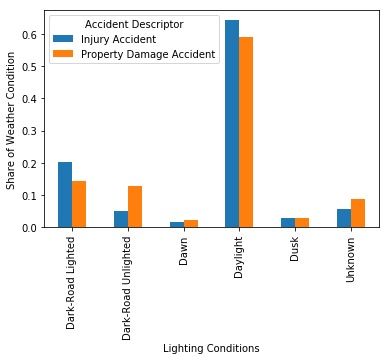

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 47500)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp

In [31]:
Light3.pivot("Lighting Conditions", "Accident Descriptor", "Lighting Conditions Share").plot(kind='bar')
plt.ylabel('Share of Weather Condition')
plt.show()